In [10]:
# !pip install opendatasets

In [11]:
import opendatasets as od

# url = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces'
# od.download(url)

In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device Available: {device}")

Device Available: cuda


In [14]:
for i in os.listdir('/content/animal-faces/afhq'):
  print(i)
  for label in os.listdir(f'/content/animal-faces/afhq/{i}'):
    print(label)
    for image in os.listdir(f'/content/animal-faces/afhq/{i}/{label}'):
      print(image)
      break
    break
  break


train
dog
pixabay_dog_003606.jpg


In [15]:
image_path = []
labels = []

for i in os.listdir('/content/animal-faces/afhq'):
  for label in os.listdir(f'/content/animal-faces/afhq/{i}'):
    for image in os.listdir(f'/content/animal-faces/afhq/{i}/{label}'):
       image_path.append(f'/content/animal-faces/afhq/{i}/{label}/{image}')
       labels.append(label)


df = pd.DataFrame(zip(image_path, labels), columns = ['image_Path', 'label'])
df.head()

,image_Path,label
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [16]:
df.label.unique()

array(['dog', 'cat', 'wild'], dtype=object)

In [17]:
df.shape

(16130, 2)

In [18]:
train = df.sample(frac=0.7)
test = df.drop(train.index)
val = test.sample(frac=0.5)

test = test.drop(val.index)

print(train.shape, test.shape, val.shape)

(11291, 2) (2419, 2) (2420, 2)


In [19]:
encoder = LabelEncoder()
encoder.fit(df['label'])


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [26]:
class ImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.lables = torch.tensor(encoder.transform(df['label'])).to(device)


  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    image_path = self.df.iloc[idx, 0]
    label = self.lables[idx]
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label


In [27]:
train_dataset = ImageDataset(train, transform=transform)
val_dataset = ImageDataset(val, transform=transform)
test_dataset = ImageDataset(test, transform=transform)

In [28]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

11291
2420
2419


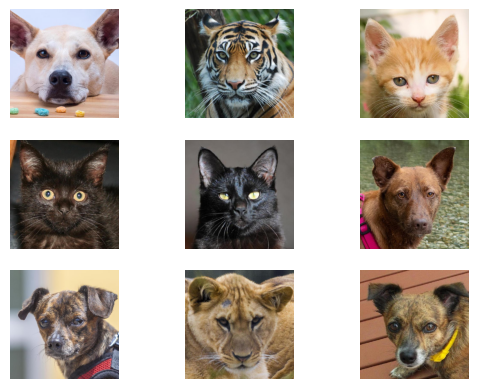

In [32]:
n_rows = 3
n_columns = 3

f, axes = plt.subplots(n_rows, n_columns)

for row in range(n_rows):
  for column in range(n_columns):
    image = Image.open(df.sample(1)['image_Path'].values[0]).convert('RGB')
    axes[row, column].imshow(image)
    axes[row, column].axis('off')

plt.show()


In [34]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

In [35]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)


test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)


In [47]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()

    self.linear = nn.Linear(128*16*16, 128)

    self.output = nn.Linear(128, len(df['label'].unique()))


  def forward(self, x):

    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)


    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x


In [48]:
model = Model().to(device)

In [49]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [65]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  # Initialize epoch-level accumulators
  epoch_train_loss = 0.0
  epoch_train_correct = 0
  epoch_train_total = 0

  # Training loop
  model.train() # Set model to training mode
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels) # Loss for current batch

    epoch_train_loss += loss.item() # Accumulate batch loss (as scalar)
    loss.backward()
    optimizer.step()

    predictions = torch.argmax(outputs, axis=1)
    epoch_train_correct += (predictions == labels).sum().item()
    epoch_train_total += labels.size(0) # Accumulate total samples

  # Validation loop
  epoch_val_loss = 0.0
  epoch_val_correct = 0
  epoch_val_total = 0

  model.eval() # Set model to evaluation mode
  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      loss = criterion(outputs, labels) # Loss for current batch

      epoch_val_loss += loss.item() # Accumulate batch loss (as scalar)

      predictions = torch.argmax(outputs, axis=1)
      epoch_val_correct += (predictions == labels).sum().item()
      epoch_val_total += labels.size(0) # Accumulate total samples

  # Calculate average loss and accuracy for the epoch
  avg_train_loss = epoch_train_loss / len(train_loader)
  avg_train_acc = epoch_train_correct / epoch_train_total * 100

  avg_val_loss = epoch_val_loss / len(val_loader)
  avg_val_acc = epoch_val_correct / epoch_val_total * 100

  total_loss_train_plot.append(avg_train_loss)
  total_loss_validation_plot.append(avg_val_loss)
  total_acc_train_plot.append(avg_train_acc)
  total_acc_validation_plot.append(avg_val_acc)

  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(avg_train_loss, 4)} Train Accuracy {round(avg_train_acc, 4)}%
              Validation Loss: {round(avg_val_loss, 4)} Validation Accuracy: {round(avg_val_acc, 4)}%''')
  print("-"*25)

Epoch 1/10, Train Loss: 0.1209 Train Accuracy 95.864%
              Validation Loss: 0.1216 Validation Accuracy: 95.5372%
-------------------------
Epoch 2/10, Train Loss: 0.0926 Train Accuracy 96.6965%
              Validation Loss: 0.1139 Validation Accuracy: 95.7851%
-------------------------
Epoch 3/10, Train Loss: 0.073 Train Accuracy 97.4493%
              Validation Loss: 0.1213 Validation Accuracy: 95.6612%
-------------------------
Epoch 4/10, Train Loss: 0.0559 Train Accuracy 97.9895%
              Validation Loss: 0.0995 Validation Accuracy: 96.4463%
-------------------------
Epoch 5/10, Train Loss: 0.0448 Train Accuracy 98.5918%
              Validation Loss: 0.1002 Validation Accuracy: 96.2397%
-------------------------
Epoch 6/10, Train Loss: 0.0372 Train Accuracy 98.7246%
              Validation Loss: 0.1205 Validation Accuracy: 95.4545%
-------------------------
Epoch 7/10, Train Loss: 0.0259 Train Accuracy 99.2738%
              Validation Loss: 0.1339 Validation Accu

In [66]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.1968 and Loss is 0.0116


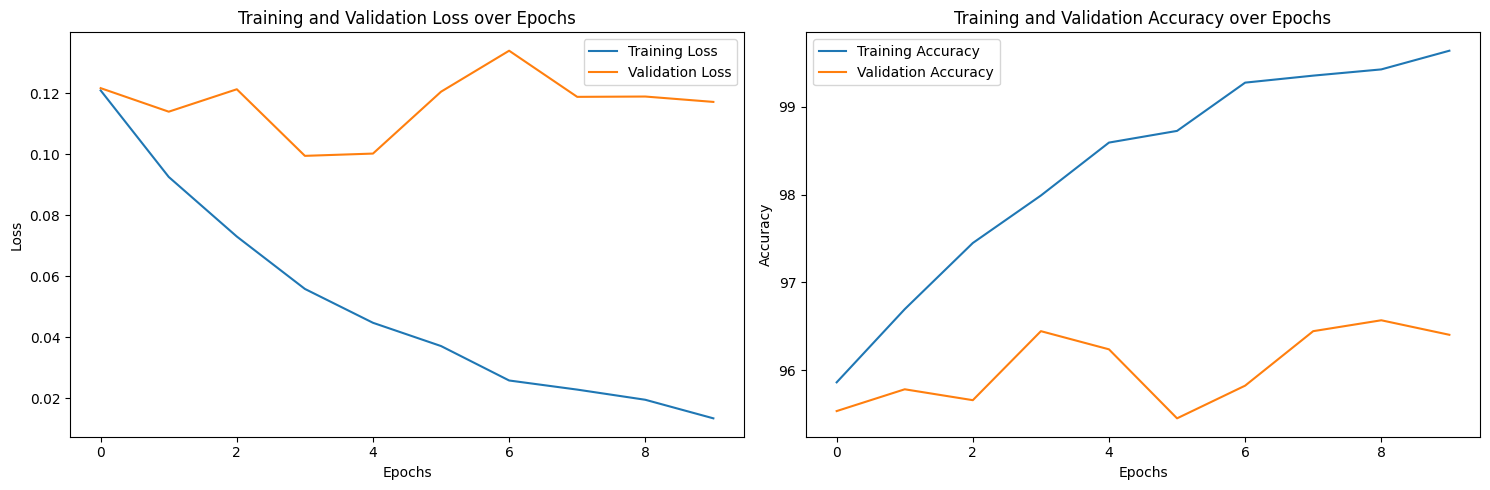

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

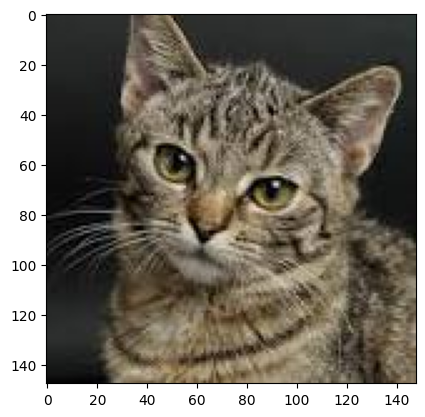


Prediction: 



array(['cat'], dtype=object)

In [69]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/cat.jpeg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/cat.jpeg")

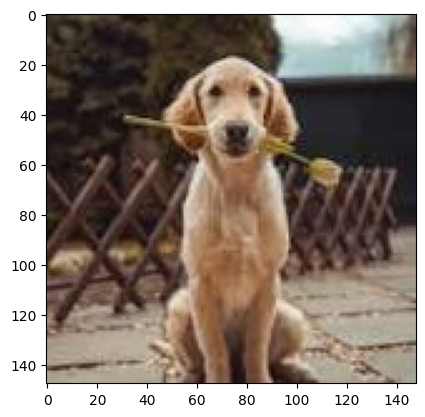


Prediction: 



array(['dog'], dtype=object)

In [70]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/dog.jpeg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/dog.jpeg")

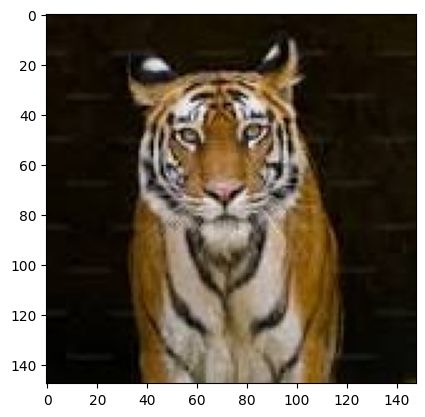


Prediction: 



array(['wild'], dtype=object)

In [71]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/wild.jpeg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/wild.jpeg")